In [1]:
# MongoDB
import pymongo
from pymongo import MongoClient

# NLP
import nltk
# from nltk.tokenize import sent_tokenize # sentence tokenization if you need
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# STD
import json
import re
import string
import random
import numpy as np
import pandas as pd
import gc
import sys
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime
from IPython import display


# Setup nltk corpora path
nltk_path = '~/nltk_data'

# Path is a list of directories where the NLTK data package might reside. 
# These directories will be checked in order when looking for a 
# resource in the data package. Note that this allows users to 
# substitute in their own versions of resources, if they have them
# (e.g., in their home directory under ~/nltk_data).
nltk.data.path.insert(0, nltk_path)

# Random seed
rseed = 4444

sns.set_context('poster')
%matplotlib inline
# %matplotlib notebook

In [ ]:
client = MongoClient('localhost', 27017)

In [ ]:
hn = client.hn

In [ ]:
client.database_names()

In [ ]:
hn.collection_names()

In [ ]:
hn.all.count()

# Structuring the Data

# Preprocessing

In [2]:
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
stop_words = set(stopwords.words())
stop_words.add('hn')
stop_words.add('http')
stop_words.add('like')
stop_words.add('would')
stop_words.add('yc')
stop_words.add('ask')
stop_words.add('p')
stop_words.add('b')
stop_words.add('href')
stop_words.add('nofollow')
stop_words.add('org')
stop_words.add('rel')
stop_words.add('id')
stop_words.add('www')
# stop_words.add('blockquote')
# stop_words.add('blockquotes')

In [4]:
def generalize_fun(corpus, lambda_fun):
    # must handle a list of lists (tokenized docs) and also a simple list
    
    if isinstance(corpus[0], list):
        # list of lists
        corpus = map(lambda_fun, corpus)
    else:
        # single list
        corpus = lambda_fun(corpus)
        
    return list(corpus)

In [5]:
def lower_alpha_num(corpus):
    # convert to lower case
    corpus = map(str.lower, corpus)
    
    # remove alpha-numerical words
    corpus = map(lambda x: re.sub(r"\w*\d\w*", '', x), corpus)
    
    # remove new lines
    corpus = map(lambda x: re.sub(r"\\n", ' ', x), corpus)
    
    return list(corpus)

In [6]:
def remove_links(corpus):
    # remove all tags
    corpus = list(map(lambda x: re.sub(r"<.*?>", "", x), corpus))
    
    # remove actual links that might be embedded
    corpus = list(map(lambda x: re.sub(r"http\S+", "", x), corpus))
    
    return corpus

In [7]:
def remove_punct(corpus):
    """Punctuation Removal"""
    # regular expression to remove punctuation
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    corpus = map(lambda x: punc_re.sub(' ', x), corpus)
    return list(corpus)

In [8]:
def remove_sws(corpus):
    """Stopword removal"""
    filter_fun = lambda x: list(filter(lambda x: x not in stop_words, x))

    corpus = generalize_fun(corpus, filter_fun)
    return list(corpus)

In [9]:
def lemmatize(corpus):
    # perform lemmatization
    lemmatizer = WordNetLemmatizer()
    
    lemmatizer_fun = lambda x: lemmatizer.lemmatize(x, get_wordnet_pos(x))
    lemmatizer_fun_outer = lambda x: list(map(lemmatizer_fun, x))

    corpus = generalize_fun(corpus, lemmatizer_fun_outer)
    return corpus

In [10]:
def get_wordnet_pos(treebank_tag):
    """Convert the part-of-speech naming scheme
       from the nltk default to that which is
       recognized by the WordNet lemmatizer"""

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [11]:
def word_tokens(corpus):
    return list(map(word_tokenize, corpus))

In [12]:
gc.collect()

678

# Yearly Topic Modelling

In [13]:
import dill

In [14]:
with open('2016_2010_threads.pkl', 'rb') as f:
    threads = dill.load(f)

In [ ]:
for i,(k,v) in enumerate(threads.items()):
    if i == 50:
        break
    print(k,v)

In [ ]:
stories = hn.all.find({"timestamp": { "$gte" : datetime(2010,1,1), 
                                      "$lte" : datetime(2010,12,31)},
                       "title"    : { "$exists" : True },
                       "type"     :   "story",
                       "descendants":{"$gte": 10}
                      })

In [ ]:
stories_2016 = hn.all.find({
                       "timestamp": { "$gte" : datetime(2016,1,1), 
                                      "$lte" : datetime(2016,12,31)},
                       "title"    : { "$exists" : True },
                       "type"     :   "story",
                       "descendants":{"$gte": 10}
                      })

In [ ]:
threads = {}
for index, data in enumerate(stories):
    _id = data['id']
    
    threads[_id] = {}
    threads[_id]['text'] = data['title']
    threads[_id]['timestamp'] = data['timestamp']
    threads[_id]['kids'] = data['kids']
    
    try:
        # catch the offchance a thread has text as well
        threads[_id]['text'] += ' ' + data['text']
    except:
        pass
    
    print(index)
    display.clear_output(wait=True)

In [ ]:
for index, data in enumerate(stories_2016):
    _id = data['id']
    
    threads[_id] = {}
    threads[_id]['text'] = data['title']
    threads[_id]['timestamp'] = data['timestamp']
    threads[_id]['kids'] = data['kids']
    
    try:
        # catch the offchance a thread has text as well
        threads[_id]['text'] += ' ' + data['text']
    except:
        pass
    
    print(index)
    display.clear_output(wait=True)

In [ ]:
# in each thread
ids = []
for data in threads.values():
    # if there are more than 10 children, randomly sample 10
    if len(data['kids']) > 10:
        children = random.sample(data['kids'], 10)
    else:
        children = data['kids']
    
    ids.extend(map(int, children))
    
# get those ids, and get the text
# add that text to the thread

In [ ]:
query_comments = hn.all.find({'id' : {'$in' : ids}})

In [ ]:
for comment in query_comments:
    _id = comment['parent']
    try:
        # catch all the deleted and other strange ones
        threads[_id]['text'] += ' ' + comment['text']
    except:
        pass
#         print('Failed on id:', comment['id'])

In [15]:
corpera = []
for data in threads.values():
    corpera.append(data['text'])

In [16]:
clean_text = lemmatize(
             remove_sws(
             word_tokens(
             remove_punct(
             remove_links(
             lower_alpha_num(corpera))))))

In [17]:
count_text = []
for i in clean_text:
    count_text.append(" ".join(i))

### Topic Modelling

In [18]:
count_vectorizer = CountVectorizer()
X = count_vectorizer.fit_transform(count_text)

In [19]:
n_topics = 60
n_iter = 10

lda = LatentDirichletAllocation(n_topics=n_topics,
                                max_iter=n_iter,
                                random_state=rseed)

lda.fit(X)

/Users/gabrielruiz/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_jobs=1, n_topics=60, perp_tol=0.1,
             random_state=4444, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [ ]:
import pyLDAvis, pyLDAvis.sklearn
from IPython.display import display

# Setup to run in Jupyter notebook
pyLDAvis.enable_notebook()

# Create the visualization
vis = pyLDAvis.sklearn.prepare(lda, X, count_vectorizer)

# # Export as a standalone HTML web page
# pyLDAvis.save_html(vis, 'lda.html')

# Let's view it!
display(vis)

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import random

def print_topic_word_clouds(model, cv, n_top_words=10):
    feature_names = cv.get_feature_names()
    
    pizza_coloring = np.array(Image.open("circle_mask.jpg"))
    
    def orange_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
        return "hsl(24, 100%%, %d%%)" % random.randint(30, 70)
#    image_colors = ImageColorGenerator(pizza_coloring)
#    image_colors= '#ff6347 '

    for topic_vec in enumerate(model.components_):
        topic_num = topic_vec[0]
        topic_words = topic_vec[1]

        print('Topic {}'.format(topic_num + 1))

        topic_values = dict(sorted(zip(feature_names,topic_words),
                              reverse=True, key=lambda x: x[1])[:n_top_words])
#         plt.figure()
    #        plt.imshow(WordCloud(background_color = 'black',mask=pizza_coloring).fit_words(topic_values).recolor(color_func=image_colors))
        (WordCloud(background_color = '#FFFFFF', mask=pizza_coloring)
                       .fit_words(topic_values)
                       .recolor(color_func=orange_color_func, random_state=3)
                       .to_file('./presentation/word_cloud/' + str(topic_num) + '.jpg'))
#         plt.imshow(WordCloud(background_color = '#FFFFFF', mask=pizza_coloring)
#                    .fit_words(topic_values)
#                    .recolor(color_func=orange_color_func, random_state=3))

#         plt.axis("off")
#         plt.title("Topic {}".format(topic_num + 1))
#         plt.show()
    #        print(' '.join([y for x,y in topic_values]))
#         print(topic_values)
        # pprint(topic_values)

    return

In [ ]:
print_topic_word_clouds(lda,count_vectorizer)

In [ ]:
pyLDAvis.save_html(vis, '2010lda.html')

In [ ]:
import dill
with open('2016_2010_threads.pkl', 'wb') as f:
    dill.dump(threads, f)

# Topics over time

In [20]:
df = pd.DataFrame.from_dict(threads, orient='index')

In [21]:
lda_data = pd.DataFrame(lda.transform(X), index=df.index)

In [22]:
def get_top_topics(row, topics=5):
    return np.argsort(row)[-topics:]

In [23]:
lda_topics = pd.DataFrame(lda_data.apply(get_top_topics, axis=1), index=df.index)

In [24]:
lda_topics.columns = ['maintopic_{}'.format(x+1) for x in range(len(lda_topics.columns))]

In [25]:
df2 = pd.concat([df, lda_topics], axis=1)

In [ ]:
# topic_names = get_topic_top_words(lda, count_vectorizer, 1)

In [ ]:
# df2 = pd.concat([df2, df2.topic_num.apply(lambda x: topic_names[x]).rename('topic_name')], axis=1)

In [55]:
topics_of_interest = [36, 25, 9, 11, 41, 48]
mask = (df2.timestamp.dt.year == 2016) & (df2.iloc[:, 3:].isin(topics_of_interest).any(axis=1))
df3 = df2[mask]
df3['month'] = df3.timestamp.dt.month
grpby = df3.groupby(['month'])
df4 = pd.concat([grpby['maintopic_1'].value_counts(), grpby['maintopic_2'].value_counts(), 
                 grpby['maintopic_3'].value_counts(), grpby['maintopic_4'].value_counts(),
                 grpby['maintopic_5'].value_counts()]).reset_index()
df5 = df4[df4.loc[:, 'maintopic_1'].isin(topics_of_interest)]
mlg3 = df5.groupby(['month','maintopic_1']).sum()
mlg4 = mlg3.pivot_table(values=0, index='month', columns='maintopic_1', aggfunc='sum').sort_values(1, ascending=False, axis=1).T
mlg4 = mlg4.div(mlg4.sum(axis=0), axis=1)

/Users/gabrielruiz/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


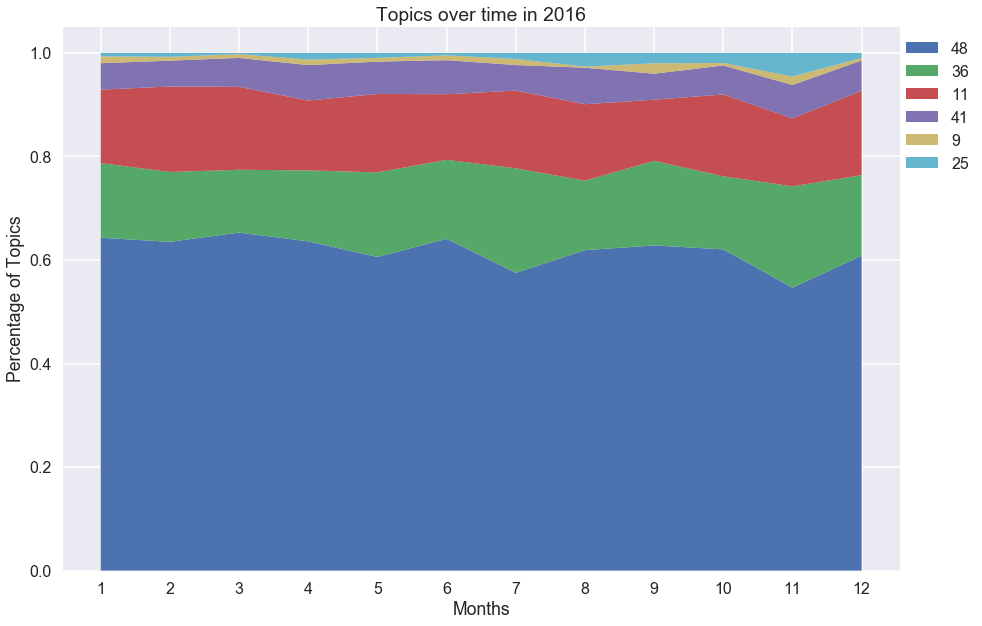

In [56]:
fig, ax = plt.subplots(figsize=(15, 10))
# ax.set_figure(10)
ax.stackplot(mlg4.columns, mlg4, labels=mlg4.index)
ax.set_xticks(range(1,13))
ax.legend(bbox_to_anchor=(1.1, 1.0));
plt.title('Topics over time in 2016')
plt.xlabel('Months')
plt.ylabel('Percentage of Topics');

In [57]:
mask = (df2.timestamp.dt.year == 2010) & (df2.iloc[:, 3:].isin(topics_of_interest).any(axis=1))
df3_ = df2[mask]
df3_['month'] = df3_.timestamp.dt.month
grpby_ = df3_.groupby(['month'])
df4_ = pd.concat([grpby_['maintopic_1'].value_counts(), grpby_['maintopic_2'].value_counts(), 
                 grpby_['maintopic_3'].value_counts(), grpby_['maintopic_4'].value_counts(),
                 grpby_['maintopic_5'].value_counts()]).reset_index()
df5_ = df4_[df4_.loc[:, 'maintopic_1'].isin(topics_of_interest)]
mlg3_ = df5_.groupby(['month','maintopic_1']).sum()
mlg4_ = mlg3_.pivot_table(values=0, index='month', columns='maintopic_1', aggfunc='sum').sort_values(1, ascending=False, axis=1).T
mlg4_ = mlg4_.div(mlg4_.sum(axis=0), axis=1)
mlg4_ = mlg4_.reindex(mlg4.index)

/Users/gabrielruiz/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


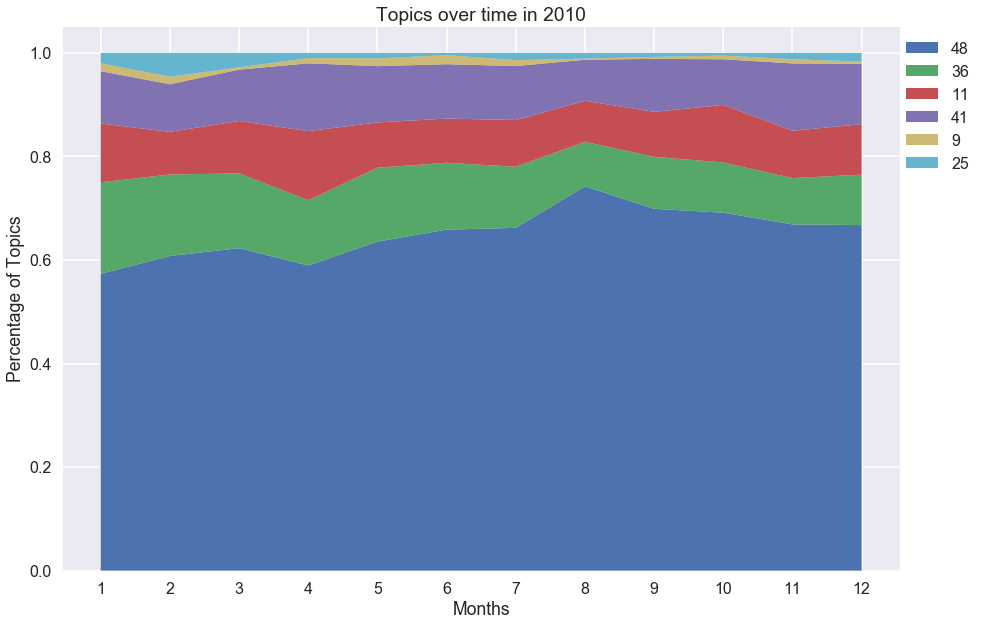

In [58]:
fig, ax = plt.subplots(figsize=(15, 10))
# ax.set_figure(10)
ax.stackplot(mlg4_.columns, mlg4_, labels=mlg4_.index)
ax.set_xticks(range(1,13))
ax.legend(bbox_to_anchor=(1.1, 1.0));
plt.title('Topics over time in 2010')
plt.xlabel('Months')
plt.ylabel('Percentage of Topics');

In [ ]:
ax = plt.axes()
ax.stackplot(mlg4.columns, mlg4, labels=mlg4.index)
ax.set_xticks(range(1,13))
ax.legend();

In [ ]:
df5.groupby(['month','maintopic_1']).sum()

In [ ]:
plt.stackplot(df5.month.unique(), df5.groupby(['month','maintopic_1']))

In [ ]:
np.row_stack(df5.iloc[:,:])

In [ ]:
print_topic_top_words(lda,count_vectorizer,5)

# Score Analysis

In [ ]:
stories = hn.all.find({"timestamp": { "$gte" : datetime(2010,1,1), 
                                      "$lte" : datetime(2010,12,31)},
                       "type"     :   "story"
                      })

In [ ]:
stories = hn.all.find({"timestamp": { "$gte" : datetime(2016,1,1), 
                                      "$lte" : datetime(2016,12,31)},
                       "type"     :   "story"
                      })

In [ ]:
threads = {}
for index, data in enumerate(stories):
    _id = data['id']
    
    threads[_id] = {}
    threads[_id]['timestamp'] = data['timestamp']
    
    try:
        threads[_id]['text'] = data['title']
    except:
        pass
    
    try:
        threads[_id]['score'] = data['score']
    except:
        pass
    
    try:
        threads[_id]['kids'] = data['kids']
    except:
        pass
    
    try:
        threads[_id]['descendants'] = data['descendants']
    except:
        pass
    
    
    try:
        # catch the offchance a thread has text as well
        threads[_id]['text'] += ' ' + data['text']
    except:
        pass
    
    print(index)
    display.clear_output(wait=True)

In [ ]:
def print_variable_memory_usage():
    for var, obj in locals().items():
        print(var, sys.getsizeof(obj))

In [ ]:
# del CountVectorizer, LatentDirichletAllocation, X, clean_text, count_text, count_vectorizer, vis, lda, stop_words
gc.collect()

In [ ]:
df = pd.DataFrame.from_dict(threads, orient='index')

In [ ]:
scores = df.score.apply(np.log)
hn_orange = '#ff6600'
hn_grey = '#f6f6ef'

plt.figure(figsize=(18,13))
ax = plt.gca()
plt.hist(scores.values,
         color=hn_orange,
         range=(0, np.ceil(scores.max())));
# sns.boxplot(df.score)
plt.title('Scores of Stories in HN - 2016');
plt.xlabel('Story Score (log)')
plt.xticks(range(0,10), ['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$', r'$10^8$', r'$10^9$', r'$10^{10}$'])
plt.ylabel('Number of Stories')
ax.set_axis_bgcolor(hn_grey)

### Checking High Score Headlines

In [ ]:
corpera = []
for data in df[df.score > 100].text.values:
    corpera.append(data)

In [ ]:
clean_text = lemmatize(
             remove_sws(
             word_tokens(
             remove_punct(
             remove_links(
             lower_alpha_num(corpera))))))

In [ ]:
count_text = []
for i in clean_text:
    count_text.append(" ".join(i))

In [ ]:
count_vectorizer = CountVectorizer()
X = count_vectorizer.fit_transform(count_text)

In [ ]:
n_topics = 30
n_iter = 10

lda = LatentDirichletAllocation(n_topics=n_topics,
                                max_iter=n_iter,
                                random_state=rseed)

lda.fit(X)

In [ ]:
def print_topic_top_words(model, cv, n_top_words=10):
    feature_names = cv.get_feature_names()
    
    for topic_vec in enumerate(model.components_):
        topic_num = topic_vec[0]
        topic_words = topic_vec[1]
        
        print('Topic {}:'.format(topic_num))
        
        topic_values = sorted(zip(topic_words, feature_names),
                              reverse=True)[:n_top_words]
        
        print(' '.join([y for x,y in topic_values]))
    
    return

def get_topic_top_words(model, cv, n_top_words=10):
    feature_names = cv.get_feature_names()
    topics = []
    
    for topic_vec in enumerate(model.components_):
        topic_num = topic_vec[0]
        topic_words = topic_vec[1]
        
        topic_values = sorted(zip(topic_words, feature_names),
                              reverse=True)[:n_top_words]
        
        topics.append('-'.join([y for x,y in topic_values]))
    
    return topics

In [ ]:
lda_data = pd.DataFrame(lda.transform(X), index=df[df.score > 100].index)

In [ ]:
lda_topics = pd.DataFrame(lda_data.apply(np.argmax, axis=1), columns=['topic_num'], index=df[df.score > 100].index)

In [ ]:
# pd.concat([lda_data.apply(np.argmax, axis=1).rename('main_topic'), lda_data],axis=1)
df2 = pd.concat([df[df.score > 100], lda_topics], axis=1)

In [ ]:
# df2.main_topic.value_counts()

In [ ]:
topic_names = get_topic_top_words(lda, count_vectorizer, 1)

In [ ]:
df2 = pd.concat([df2, df2.topic_num.apply(lambda x: topic_names[x]).rename('topic_name')], axis=1)

In [ ]:
print_topic_top_words(lda,count_vectorizer,5)

In [ ]:
df2[df2.topic_num == 14].text.apply(print)

In [ ]:
def func(x):
    if type(x) == list:
        return len(x)
    else:
        # the nans will get ya
        return 0

In [ ]:
# df2['num_kids'] = df2.kids.apply(func)

In [ ]:
# columns = list(df2.columns[:4]) + ['main_topic', 'topic_name', 'num_kids']

In [ ]:
# df2.columns = columns

In [ ]:
# df2.head()

In [ ]:
df3 = df2.groupby(['topic_num', 'topic_name']).sum().reset_index()

In [ ]:
df3

In [ ]:
N = df3.topic_num.count() # Number of labels

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,N,N+1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

with sns.axes_style("darkgrid"):
    with sns.plotting_context('poster', font_scale=1.3):
        fig, ax = plt.subplots(1,1, figsize=(25,15))
        scatter = ax.scatter(np.log(df3.descendants), np.log(df3.score),
                             s=30,
                             alpha=1,
                             norm=norm,
                             c=df3.topic_num,
                             cmap=cmap)
        # cb = plt.colorbar(scatter, spacing='proportional',ticks=bounds)
        # cb.set_label('Topics')

        ax.set_xlabel('Comments (log)')
        ax.set_ylabel('Score (log)')

        for xy in zip(np.log(df3.descendants), np.log(df3.score), df3.topic_name):
            nudge = 0.007
            ax.annotate('%s' % xy[2], xy=(xy[0]+nudge+nudge, xy[1]-0.003), textcoords='data', fontsize=16)
        ax.set_title('Topics Mapped to Scores and Comments');

In [ ]:
df3['score_log'] = np.log(df3.score)
df3['descendants_log'] = np.log(df3.descendants)

In [ ]:
df3.descendants_log.describe()

In [ ]:
sns.set(style="darkgrid", color_codes=True)
plt.figure(figsize=(8, 6))
plt.scatter(df3.descendants_log, df3.score_log, marker='.');
# plt.legend()
# sns.swarmplot(x="descendants_log", y="score_log", data=df3, hue="topic_num")
# plt.xticks(range(0,50), range(0,50));

In [ ]:
import pyLDAvis, pyLDAvis.sklearn
from IPython.display import display

# Setup to run in Jupyter notebook
pyLDAvis.enable_notebook()

# Create the visualization
vis = pyLDAvis.sklearn.prepare(lda, X, count_vectorizer)

# # Export as a standalone HTML web page
# pyLDAvis.save_html(vis, 'lda.html')

# Let's view it!
display(vis)

# Searching for 2016


In [ ]:
# In 2008 there was 6153 articles that produced over commentary greater than 10
6153/365

In [ ]:
import requests
from datetime import datetime

In [ ]:
jan2016 = 10821140
t2 = requests.get('https://hacker-news.firebaseio.com/v0/item/' + str(jan2016) + '.json?print=pretty')
datetime.fromtimestamp(t2.json()['time'])

In [ ]:
dec2016 = 13294752
t2 = requests.get('https://hacker-news.firebaseio.com/v0/item/' + str(dec2016) + '.json?print=pretty')
datetime.fromtimestamp(t2.json()['time'])

In [ ]:
(dec2016-jan2016)/4

In [ ]:
10821140 + 618403 + 618403

In [ ]:
11439543 - 11532315

In [ ]:
X.shape